# **Display 3D GroundTruth** 
***

## Dataset
[KITTI 2011_09_26_drive_0005 dataset](http://www.cvlibs.net/datasets/kitti/raw_data.php?type=city)  
In this code, rectified image is used.

refer to [KITTI Dataset Paper](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf) for the details of data measurement environment

## Objective

Display tracklet

In [1]:
import numpy as np
import glob
from src import parseTrackletXML as pt_XML
from kitti_foundation import Kitti, Kitti_util
%matplotlib inline

In [2]:
image_type = 'color'  # 'gray' or 'color' image
mode = '00' if image_type == 'gray' else '02'  # image_00 = 'graye image' , image_02 = 'color image'

image_path = 'image_' + mode + '/data'
velo_path = './velodyne_points/data'
xml_path = "./tracklet_labels.xml"
v2c_filepath = './calib_velo_to_cam.txt'
c2c_filepath = './calib_cam_to_cam.txt'
frame = 89

check = Kitti_util(frame=frame, velo_path=velo_path, camera_path=image_path, \
                   xml_path=xml_path, v2c_path=v2c_filepath, c2c_path=c2c_filepath)

# bring velo points & tracklet info
points = check.velo_file
tracklet_, type_ = check.tracklet_info

print(points.shape)
print('The number of GT : ', len(tracklet_[frame]))


parsing tracklet file ./tracklet_labels.xml
file contains 15 tracklets
loaded 15 tracklets
(123749, 3)
The number of GT :  3


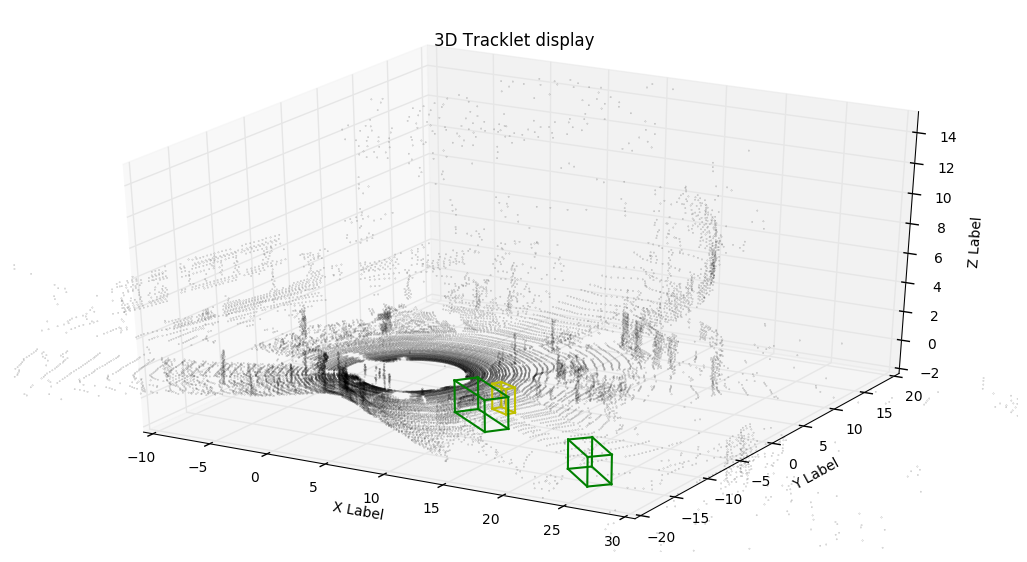

In [3]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def draw_3d_box(tracklet_, type_):
    """ draw 3d bounding box """
    
    type_c = { 'Car': 'b', 'Van': 'g', 'Truck': 'r', 'Pedestrian': 'c', \
          'Person (sitting)': 'm', 'Cyclist': 'y', 'Tram': 'k', 'Misc': 'w'}
    
    line_order = ([0, 1], [1, 2],[2, 3],[3, 0], [4, 5], [5, 6], \
             [6 ,7], [7, 4], [4, 0], [5, 1], [6 ,2], [7, 3])

    for i, j in zip(tracklet_[frame], type_[frame]):
        for k in line_order:    
            ax.plot3D(*zip(i.T[k[1]],i.T[k[0]]), lw = 1.5, color=type_c[j])

fig = plt.figure(figsize=(13, 7))
ax = fig.add_subplot(111, projection='3d')
plt.title("3D Tracklet display")
pnt = points.T[:, 1::5] # one point in 5 points

ax.scatter(*pnt, s = 0.1, c='k', marker='.', alpha=0.5)

draw_3d_box(tracklet_, type_)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

ax.set_xlim3d(-10,30)
ax.set_ylim3d(-20,20)
ax.set_zlim3d(-2,15)

plt.show()

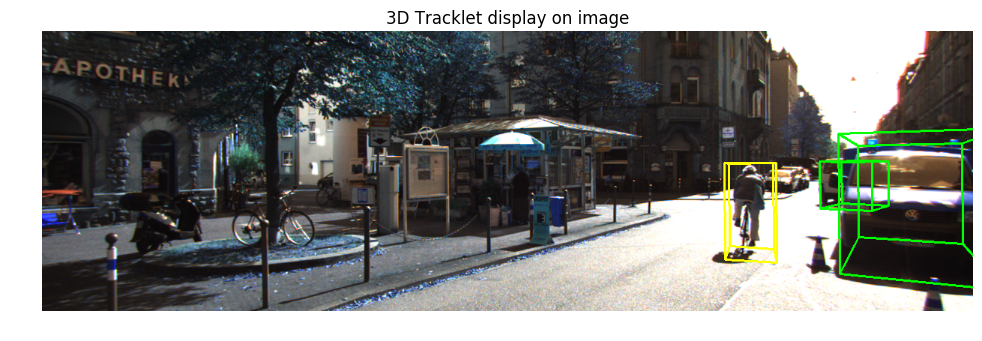

In [4]:
import cv2

frame = 89
image = check.camera_file
tracklet_, type_ = check.tracklet_info

tracklet2d = []
for i, j in zip(tracklet_[frame], type_[frame]):
    point = i.T
    chk,_ = check._Kitti_util__velo_2_img_projection(point)
    tracklet2d.append(chk)

type_c = { 'Car': (0, 0, 255), 'Van': (0, 255, 0), 'Truck': (255, 0, 0), 'Pedestrian': (0,255,255), \
      'Person (sitting)': (255, 0, 255), 'Cyclist': (255, 255, 0), 'Tram': (0, 0, 0), 'Misc': (255, 255, 255)}

line_order = ([0, 1], [1, 2],[2, 3],[3, 0], [4, 5], [5, 6], \
         [6 ,7], [7, 4], [4, 0], [5, 1], [6 ,2], [7, 3])

for i, j in zip(tracklet2d, type_[frame]):
    for k in line_order:    
        cv2.line(image, (int(i[0][k[0]]), int(i[1][k[0]])), (int(i[0][k[1]]), int(i[1][k[1]])), type_c[j], 2)

plt.subplots(1,1, figsize = (12,4))
plt.title("3D Tracklet display on image")
plt.axis('off')
plt.imshow(image)